In [1]:
%env CUDA_VISIBLE_DEVICES=1
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=1


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss


def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

def train_sampling_pattern(train_generator, model, n=14):
    c, bmasks, images, bmean, bstd = next(iter(train_generator))
    bks = Ft(images * bstd + bmean)
    bgt = IFt(bks).abs()
    w = torch.zeros(256).cuda().float()
    w[128] = 1
    bbatch = 32
    w_list = []
    pbar = tqdm(range(n))
    for count in pbar:
        w = torch.autograd.Variable(w, requires_grad=True)
        for j in range(bks.shape[0] // bbatch):
            bbks = bks[bbatch*j:bbatch*(j+1)].cuda()
            bbgt = bgt[bbatch*j:bbatch*(j+1)].cuda()
            bbmean = bmean[bbatch*j:bbatch*(j+1)].cuda()
            bbstd = bstd[bbatch*j:bbatch*(j+1)].cuda()
            bbmasks = bmasks[bbatch*j:bbatch*(j+1)].cuda()
            recs = IFt(bbks * w).abs()
            pm = model((recs - bbmean) / (bbstd + 1e-11))
            loss = dice_loss(bbmasks.long(), pm)
            loss.backward()
        for i in torch.topk(w.grad, 256, largest=False).indices:
            if w[i] == 0: 
                w = w.detach()
                w[i] = 1.
                w_list.append(w.clone())
                pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                break
    return w_list

def test_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    bbatch = 32
    for j in tqdm(range(vbks.shape[0] // bbatch), disable=True):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].cuda()
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].cuda()
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].cuda()
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].cuda()
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].cuda()
        with torch.no_grad():
            # igs
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            for i in range(recs.shape[0]):
                dice_scores.append(1 - dice_loss(vbbmasks.long(), pm).item())
    return dice_scores

def test_on_classes_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    bbatch = 1
    for j in tqdm(range(vbks.shape[0] // bbatch), disable=True):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].cuda()
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].cuda()
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].cuda()
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].cuda()
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].cuda()
        with torch.no_grad():
            # igs
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            for i in range(recs.shape[0]):
                dice_scores.append(dice_coeffs(vbbmasks.long(), pm))
    return dice_scores

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path: str):
        super().__init__()
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return c, mask, img, mean.unsqueeze(0).unsqueeze(0).unsqueeze(0), std.unsqueeze(0).unsqueeze(0).unsqueeze(0)

In [3]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [4]:
train_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/train.h5')
val_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/val.h5')
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=6)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('unet-acdc-1.pt'))

<All keys matched successfully>

# Acceleration curve

In [ ]:
w_list = train_sampling_pattern(train_generator, model, n=64)
torch.save(w_list, 'sampling_igs_list.pt')

In [6]:
w_list = torch.load('sampling_igs_list.pt')

In [7]:
def get_acceleration_dice_scores(acceleration_factor):
    fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.02], [acceleration_factor])((256, 256))[0]).cuda().float()
    zm = torch.zeros(256).cuda().float()
    zm[256//2 - int(fastmri_mask_x16.sum())//2 : 256//2 + int(fastmri_mask_x16.sum())//2] = 1
    fm = torch.ones(256).cuda().float()
    w = w_list[int(fastmri_mask_x16.sum() - 2)]
    dice_scores = dict(
        fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model, val_generator), 
        center=test_on_classes_sampling_pattern(zm, model, val_generator),
        ours=test_on_classes_sampling_pattern(w, model, val_generator),
    )
    return dice_scores

In [21]:
import contextlib
acceleration_curve = []
acc_vals = np.logspace(start=2, stop=5.6, base=2, num=24)
for ax in tqdm(acc_vals):
    acceleration_curve.append(get_acceleration_dice_scores(ax))
with open('acceleration_curve.pkl', mode='wb') as f: pickle.dump((acceleration_curve, acc_vals), f)

In [22]:
with open('acceleration_curve.pkl', 'rb') as f: acceleration_curve, acc_vals = pickle.load(f)

In [23]:
df_curve = pd.DataFrame.from_dict({
    'fastmri': [np.mean(np.array(v['fastmri'])[:,:]) for v in acceleration_curve],
    'center': [np.mean(np.array(v['center'])[:,:]) for v in acceleration_curve],
    'ours': [np.mean(np.array(v['ours'])[:,:]) for v in acceleration_curve],
})

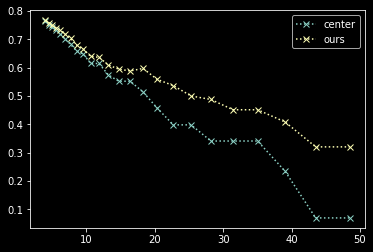

In [24]:
# plt.plot(acc_vals, df_curve.fastmri, 'x:', label='fastmri')
plt.plot(acc_vals, df_curve.center, 'x:', label='center')
plt.plot(acc_vals, df_curve.ours, 'x:', label='ours')
plt.legend()
plt.show()